# ASEN 6519 Fall 2018 - Midterm Project 
## Extended KF and Ensemble Filters with Lorenz-63

### The Lorenz-63 Model
Low-dimensional model: the state is made of 3 variables $x = (x1, x2, x3)$ and dynamical system evolution is given by the following equations:

$$\frac{\partial x_1}{\partial t} = -Ax_1 + Ax_2$$
$$\frac{\partial x_2}{\partial t} = Bx_1 - x_1x_3 - x_2$$
$$\frac{\partial x_3}{\partial t} = x_1x_2 - Cx_3$$

where $A=10$, $B=28$, and $C=8/3$.

In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def dfdt(r, coeffs):
    '''
    Returns dx1/dt, dx2/dt, dx3/dt
    '''
    # Current position
    x1 = r[0]
    x2 = r[1]
    x3 = r[2]
    
    # Extract coefficients
    A = coeffs[0]
    B = coeffs[1]
    C = coeffs[2]
    
    # Calculate the derivative
    dx1 = -A*x1 + A*x2
    dx2 = B*x1 - x1*x3 - x2
    dx3 = x1*x2 - C*x3
    
    return np.array([dx1, dx2, dx3], float)

In [40]:
def dPdt(P, A, Q):
    '''
    Returns dP/dt; From Simon's "Optimal State Estimation", Eqn 13.28
    
    Inputs:
        - P: covariance of the state
        - A: the TLM
        - Q: noise
    '''
    
    return A@P + P@A.T + Q

In [41]:
def advance_time(r, coeffs, h):
    '''
    Calculate the state of the system at time t+1 using RK2
    
    Inputs:
        r - the state
        coeffs - the standard Lorenz system coefficients
        h - timstep
    '''
    
    # Calculate Runge-Kutta2 coefficients
    k1 = h*dfdt(r, coeffs)
    k2 = h*dfdt(r+0.5*k1, coeffs)
    
    # Update current position
    r += k2
    
    return r

In [42]:
def advance_cov(P, M, Q, h):
    '''
    Calculate the covariance P at time t+1 using RK2
    '''
    
    # Calculate Runge-Kutta2 coefficients
    k1 = h*dPdt(P, M, Q)
    k2 = h*dPdt(P+0.5*k1, M, Q)
    
    # Update current position
    P += k2
    
    return P

In [43]:
def calc_TLM(x):
    global A_lor, B_lor, C_lor
    
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    
    return np.array([
        [-A_lor,   A_lor,  0.0],
        [B_lor-x3, -1.0,  -x1],
        [x2,       x1,    -C_lor]])

### 1. Generate $true$ state and synthetic observations using Lorenz63 setup with the default inputs.

#### Setup Model
# ================== FIXED ==================

In [44]:
## Background error variance
B_struct_Identity = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])

## Set up necessary matrixies
H = np.eye(3)
I = np.eye(3)

# Note: dont have usehigh order scheme
# note forget about Q
## Model error covariance (ie: process noise), from Evensen 1997
Q = np.zeros((3,3))
Q[0,0] = 0.1491
Q[0,1] = 0.1505
Q[0,2] = 0.0007
Q[1,0] = 0.1505
Q[1,1] = 0.9048
Q[1,2] = 0.0014
Q[2,0] = 0.0007
Q[2,1] = 0.0014
Q[2,2] = 0.9180
# Qsqrt_cov = np.linalg.cholesky(Q)
L, V = np.linalg.eig(Q)
Qsqrt_cov = V*np.sqrt(L)    # TODO: Why this?

## Misc errors which I do not understand yet but need to run the system
varobs = 3   # Observation error variance
svar = 0.3

## Measurement covariance
sobs = np.sqrt(varobs)
R_struct = np.eye(3)
R = varobs * R_struct
L, V = np.linalg.eig(R)
Msqrt_cov = V*np.sqrt(L)


## Model setup  (Do not change)
N_state = 3 # Number of state variables
MO = 3      # Number of measurement variables
# Default Lorenz system parameters
A_lor = 10  
B_lor = 28
C_lor = 8/3
coeffs = np.array([A_lor, B_lor, C_lor],float)


# Numerical parameters (don't change)
t0 = 0          # sec, initial time
tf_assim = 3    # sec, final time   of forecast
tf_fore = 1     # sec, final length of forecast
h_sys = 0.01    # sec, timestep for system dynamics

### 2. Implement your own EKF to estimate $x_a$. The tangent linear and adjoint codes are provided.
 - Investigate the performance of filter in terms of the bias and mean-square-error of data assimilation analysis. How does the estimate-error computed from $x_a$ and the truth value of $x$ compare to the error variance suggested by the posterior covariance?
 - Examine the sensitivity of the filter performance to the errors in the background. (Compare at least 10 cases)
 - Examine the sensitivity of the filter performance to the accuracy and frequency of observations. Is it better to have frequent but inaccurate observations or infrequent but accurate ones? (Compare at least $10\times 10$ cases.)
 
 **EKF Algorithm** (Lecture 6, Slide 9)
 * Note
     * $M_{nl}$ and $H_nl$ are the true nonlinear forward model and observation models, and $M$ and $H$ are the tangent linear models of the nonlinear operators 
     * where $M_t = \frac{\delta M_{nl}}{\delta x}$, evaluated at $x = x^a_{t-1}$
     * Our $H$ is linear for this problem
 * *Forecast* 
     * $x^f_t = M_{nl}(x^a_{t-1})$
     * $P^f_t = M_{t} P^a_{t-1} M^T_t + Q_t$
 * *Update*
     * $x^a_t = x^f_t + K_t (y_t - H_{nl}(x^f_t))$
     * $P^a_t = (I - K_t H_t) P^f_t$
     * where $K_t = P^f_t H^T_t(R_t + H_t P^f_t H^T_t)^{-1}$

# ============= Subject to change =============
#### Setup Errors/Covariances
#### Run the System: Generate States ($x_{true}$)

In [45]:
# =================== To change observation size ===================
# Examine the sensitivity of the filter performance to the errors in the background. 
# (Compare at least 10 cases)
B_cov = B_struct_Identity * 0.1


# =================== To change observation size ===================
# Examine the sensitivity of the filter performance to the accuracy and frequency of observations. 
dyn2meas = 20   # Number of dynamics updates per measurement (changes obs size)
dyn2meas = 20   # Change frequency of observations.

# Change frequency of observations.
varobs = 1

h_obs = h_sys * dyn2meas     # sec; an observation is generated every h_obs sec
t_sys = np.arange(t0,tf_assim,h_sys)     # time stamps for system dynamics
t_obs = np.arange(t0,tf_assim,h_obs)     # time stamps for observations
N_sys = len(t_sys)               # Number of system timesteps
N_obs = len(t_obs)               # Number of observations
print (f'N-obs={N_obs} N-state={N_sys}')

## Initial conditions
y = np.zeros([MO, N_obs])  # Measurements of x1 (with measurement noise)

# =================== Generate True state ===================
## Iterate through time and simulate dynamics
# default input parameters, she uses 'astr' name
x1_0 = 1.5
x2_0 = -1.5
x3_0 = 25.5

r = np.array([[x1_0, x2_0, x3_0]], float).T   # "Current" position
x_true = np.zeros([N_state, N_sys])  # True history of x1 (without any noise)
x_true[:,0] = np.squeeze(r)

for i in range(1,N_sys):
    x_true[:,i] = advance_time(x_true[:,i-1], coeffs, h_sys)

#plt.figure(figsize=[15,5])
#plt.subplot(1,3,1) ; plt.plot(x_true[0,:],x_true[1,:]);plt.ylim(-20,50);plt.xlim(-30,30)
#plt.plot(x_s[0,:],x_s[1,:])

#plt.subplot(1,3,2)
#plt.plot(x_true[0,:],x_true[2,:]); plt.ylim(-20,50);plt.xlim(-30,30)
#plt.plot(x_s[0,:],x_s[2,:]) 

#plt.subplot(1,3,3) ; plt.plot(x_true[1,:],x_true[2,:]);plt.ylim(-20,50);plt.xlim(-30,30)
#plt.plot(x_s[1,:],x_s[2,:])
#plt.show()

# =================== Generate Measurements ===================
# add in variance "varobs" which was np.random.randn(3,1)
for i in range(N_obs):
    curr_state = x_true[:,i*dyn2meas][:,np.newaxis]
    y[:,i] = np.squeeze(curr_state + Msqrt_cov @ (np.random.randn(3,1)*varobs))

#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure(figsize=[8,8])
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(x_true[0,:],x_true[1,:],x_true[2,:],label='$x_{true}$')
#ax.scatter(x_s[0,:],x_s[1,:],x_s[2,:],label='$x_{noisy}$')#,s=100,marker='x')
#ax.scatter(y[0,:],y[1,:],y[2,:],label='Obs')#,s=100,marker='x')
#ax.legend(loc=6)
#plt.show()

## Store histories
xf_EKF = np.array(np.zeros([3, N_sys]))
Pf_EKF = np.zeros(shape=[3,3,N_sys])
xa_EKF = np.array(np.zeros([3, N_obs]))
Pa_EKF = np.zeros(shape=[3,3, N_obs])

## ICs for the EKF
xa = np.array([[y[0,0], y[1,0], y[2,0]]], float).T
Pa = B_cov.copy()
Pf = B_cov.copy()

xf_EKF[:,0] = y[:,0].copy()
Pf_EKF[:,:,0] = Pa.copy()
xa_EKF[:,0] = y[:,0].copy()
Pa_EKF[:,:,0] = Pa.copy()

#### Run the EKF
## Initialization
## Current values
for j in range(1,dyn2meas+1):  
    curr_state = xf_EKF[:,j-1]
    curr_P = Pf_EKF[:,:,j-1]
    prev_analysis_state = xa_EKF[:,0]
    M = calc_TLM(prev_analysis_state.copy())

    ## Forecast to next timestep
    xf = advance_time(curr_state.copy(), coeffs, h_sys)  # Forecast to next time step
    Pf = advance_cov(curr_P.copy(), M, Q, h_sys)
    xf_EKF[:,j], Pf_EKF[:,:,j] = xf.copy(), Pf.copy()

for i in range(1,N_obs):
    #### Update
    x1, x2, x3 = xf[0], xf[1], xf[2]
    y_t = y[:,i]
    M = np.array([          # The tangent linear model evaluated at x=xf_k
        [-A_lor  ,  A_lor  ,  0.0],
        [B_lor-x3, -1.0,  -x1],
        [x2  , x1  ,  -C_lor]])
    
    K = Pf @ H.T @ np.linalg.inv(R + H@Pf@H.T)  # Kalman gain
    xa = xf + K @ (y_t - H @ xf)   # Update mean
    Pa = (I - K @ H) @ Pf   # Update covar
    xa_EKF[:,i], Pa_EKF[:,:,i] = xa.copy(), Pa.copy()  # Store update

    #### Forecast
    for j in range(1,dyn2meas+1):   
        
        ## Special case: end condition
        if i*dyn2meas+j >= N_sys:
            break
            
        ## Special case: first forecast after an obs
        if j == 1:
            ## Current values
            curr_state = xa_EKF[:,i]
            curr_P = Pa_EKF[:,:,i]
            M = calc_TLM(curr_state.copy())
            
            ## Forecast
            xf = advance_time(curr_state.copy(), coeffs, h_sys)  # Forecast to next time step
            Pf = advance_cov(curr_P.copy(), M, Q, h_sys)
            xf_EKF[:,i*dyn2meas+j], Pf_EKF[:,:,i*dyn2meas+j] = xf.copy(), Pf.copy()
        
        else:
            ## Current values
            curr_state = xf_EKF[:,i*dyn2meas+j-1]
            curr_P = Pf_EKF[:,:,i*dyn2meas+j-1]
            prev_analysis_state = xa_EKF[:,i]
            M = calc_TLM(prev_analysis_state.copy())

            ## Forecast to next timestep
            xf = advance_time(curr_state.copy(), coeffs, h_sys)  # Forecast to next time step
            Pf = advance_cov(curr_P.copy(), M, Q, h_sys)
            xf_EKF[:,i*dyn2meas+j], Pf_EKF[:,:,i*dyn2meas+j] = xf.copy(), Pf.copy()

N-obs=15 N-state=300


In [46]:
## Store histories
xf_EKF = np.array(np.zeros([3, N_sys]))
Pf_EKF = np.zeros(shape=[3,3,N_sys])
xa_EKF = np.array(np.zeros([3, N_obs]))
Pa_EKF = np.zeros(shape=[3,3, N_obs])

## ICs for the EKF
xa = np.array([[y[0,0], y[1,0], y[2,0]]], float).T
Pa = B_cov.copy()
Pf = B_cov.copy()

xf_EKF[:,0] = y[:,0].copy()
Pf_EKF[:,:,0] = Pa.copy()
xa_EKF[:,0] = y[:,0].copy()
Pa_EKF[:,:,0] = Pa.copy()

#### Run the EKF
## Initialization
## Current values
for j in range(1,dyn2meas+1):  
    curr_state = xf_EKF[:,j-1]
    curr_P = Pf_EKF[:,:,j-1]
    prev_analysis_state = xa_EKF[:,0]
    M = calc_TLM(prev_analysis_state.copy())

    ## Forecast to next timestep
    xf = advance_time(curr_state.copy(), coeffs, h_sys)  # Forecast to next time step
    Pf = advance_cov(curr_P.copy(), M, Q, h_sys)
    xf_EKF[:,j], Pf_EKF[:,:,j] = xf.copy(), Pf.copy()

for i in range(1,N_obs):
    #### Update
    x1, x2, x3 = xf[0], xf[1], xf[2]
    y_t = y[:,i]
    M = np.array([          # The tangent linear model evaluated at x=xf_k
        [-A_lor  ,  A_lor  ,  0.0],
        [B_lor-x3, -1.0,  -x1],
        [x2  , x1  ,  -C_lor]])
    
    K = Pf @ H.T @ np.linalg.inv(R + H@Pf@H.T)  # Kalman gain
    xa = xf + K @ (y_t - H @ xf)   # Update mean
    Pa = (I - K @ H) @ Pf   # Update covar
    xa_EKF[:,i], Pa_EKF[:,:,i] = xa.copy(), Pa.copy()  # Store update

    #### Forecast
    for j in range(1,dyn2meas+1):   
        
        ## Special case: end condition
        if i*dyn2meas+j >= N_sys:
            break
            
        ## Special case: first forecast after an obs
        if j == 1:
            ## Current values
            curr_state = xa_EKF[:,i]
            curr_P = Pa_EKF[:,:,i]
            M = calc_TLM(curr_state.copy())
            
            ## Forecast
            xf = advance_time(curr_state.copy(), coeffs, h_sys)  # Forecast to next time step
            Pf = advance_cov(curr_P.copy(), M, Q, h_sys)
            xf_EKF[:,i*dyn2meas+j], Pf_EKF[:,:,i*dyn2meas+j] = xf.copy(), Pf.copy()
        
        else:
            ## Current values
            curr_state = xf_EKF[:,i*dyn2meas+j-1]
            curr_P = Pf_EKF[:,:,i*dyn2meas+j-1]
            prev_analysis_state = xa_EKF[:,i]
            M = calc_TLM(prev_analysis_state.copy())

            ## Forecast to next timestep
            xf = advance_time(curr_state.copy(), coeffs, h_sys)  # Forecast to next time step
            Pf = advance_cov(curr_P.copy(), M, Q, h_sys)
            xf_EKF[:,i*dyn2meas+j], Pf_EKF[:,:,i*dyn2meas+j] = xf.copy(), Pf.copy()

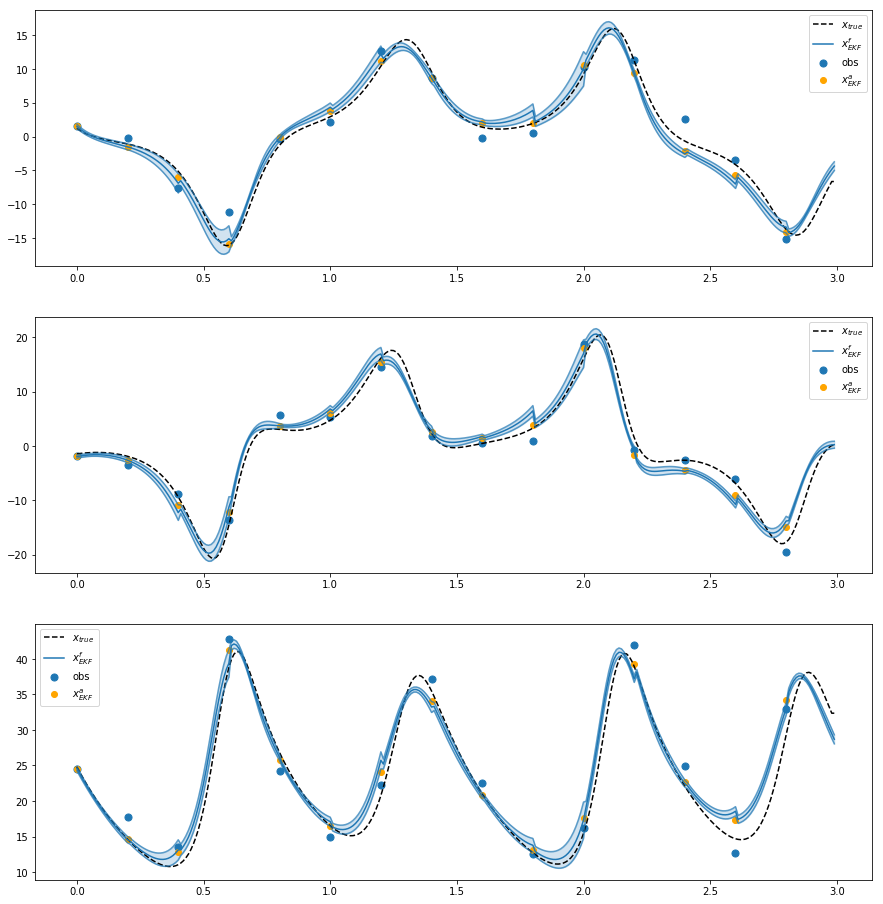

In [52]:
## Plot EKF analysis
plt.figure(figsize=[15,16])

## Plot x1
for S in range(3):
    plt.subplot(3,1,S+1)
    plt.plot(t_sys, x_true[S,:], color='black', label='$x_{true}$', ls='--')
    plt.scatter(t_obs, y[S,:], s=50, label='obs')
    plt.plot(t_sys, np.ravel(xf_EKF[S,:]),color='C0',label='$x^f_{EKF}$')
    plt.plot(t_sys, np.ravel(xf_EKF[S,:] + np.sqrt(Pf_EKF[0,0,:])),color='C0', alpha=0.7)
    plt.plot(t_sys, np.ravel(xf_EKF[S,:] - np.sqrt(Pf_EKF[0,0,:])),color='C0', alpha=0.7)
    plt.fill_between(t_sys, np.ravel(xf_EKF[S,:] + np.sqrt(Pf_EKF[0,0,:])), \
                            np.ravel(xf_EKF[S,:] - np.sqrt(Pf_EKF[0,0,:])), color='C0', alpha=0.2)
    plt.scatter(t_obs, np.ravel(xa_EKF[S,:]),color='orange',label='$x^a_{EKF}$')
    plt.legend()

plt.show()

### 3. Implement your own EnKF (with perturb observations) or EnSRF to estimate $x_a$.
 - Initialize the ensemble by introducing small perturbations to the state and integrating the model until its error growth saturates.
 - Compare the performance of the ensemble method to EKF with respect to each sub-question above. Launch ensemble forecasts (instead of deterministic forecasts) at the end of the assimilation period.
 - Evaluate the ensemble by using rank histograms.
 - Examine the impact of increasing or decreasing ensemble size on the filter performance as well as the forecast performance.

 **Stochastic EnKF Algorithm** (Katzfuss 2016)
 * *Note* — Notational consistency: $\widetilde{x} = x^f$ and $\hat x = x^a$
 * Start with an initial ensemble $\hat x_0^{(1)}, ..., \hat x_0^{(N)}$
 * Then at each time $t = 1, 2, ...$, given an ensemble $\hat x_{t-1}^{(1)}, ..., \hat x_{t-1}^{(N)}$ of draws from the filtering (posterior) distribution at time $t-1$ the stochastic EnKF carries out the following two steps for $i = 1, ..., N$.
 * *Forecast* — Draw process noise $w_t^{(i)} \sim N_n(0, Q_t)$ and calculate $\widetilde{x}_t^{(i)} = M_t \hat x_{t-1}^{(i)} + w_t^{(i)}$
 * *Update* — Draw sensor noise $v_t^{(i)} \sim N_{m_t} (0, R_t)$ and calculate $\hat x_t^{(i)} = \widetilde{x}_t^{(i)} + \hat K_t(y_t - \widetilde{y}_t^{(i)} )$
     * where $y_t$ is the actual observation
     * and $\widetilde{y}_t^{(i)} = H_t \widetilde{x}_t^{(i)} - v_t^{(i)}$  is the simulated observation
     * and where $\hat K_t = C_tH_t^T(H_tC_tH_t^T + R_t)^{-1}$
     * and $C_t$ is an estimate of the state forecast covariance matrix $\widetilde{\Sigma}_t$. The simplest example is $C_t = \widetilde{S}_t$, where $\widetilde{S}_t$ is the sample covariance matrix of $\widetilde{x}_t^{(1)}, ..., \widetilde{x}_t^{(N)}$


In [ ]:
## Generate initial ensemble
N_ens = 25   # number of ensemble members
xtld_hist = np.zeros((3, N_ens, N_sys))  # History of forecasts (x tilde)
xhat_hist = np.zeros((3, N_ens, N_obs))  # History of updated x's (x hat)
Ptld_hist = np.zeros((3, 3, N_sys))
muw = np.zeros(3)   # the mean of process noise
mvw = np.zeros(3)   # the mean of sensor noise
Qh0 = Q               # initlal Q
w0 = np.random.multivariate_normal(muw, Qh0, size=N_ens).T  # Perturbations for the IC
x0_pure = np.array([[y[0,0], y[1,0], y[2,0]]]).T   # Unperturbed IC
xh0 = x0_pure + w0 # Initial position of ensemble members
xtld_hist[:,:,0] = xh0
xhat_hist[:,:,0] = xh0

# #### Run the EnKF
# ## Initialization
# ## Current values
for j in range(1,dyn2meas+1):  
    curr_state = xtld_hist[:,:,j-1].copy()
    w = np.random.multivariate_normal(muw, Q, size=N_ens).T
    xtld = advance_time(curr_state.copy(), coeffs, h_sys) + w # Noisy forecast
    Ptld = np.cov(xtld)      # Sample covariance calculation
    xtld_hist[:,:,j] = xtld.copy()
    Ptld_hist[:,:,j] = Ptld
    
## Move through time
for i in range(1,N_obs):
    ## Update
    Ct = np.cov(xtld)    # Calculate sample covariance
    Kt = Ct @ H.T @ np.linalg.inv(H @ Ct @ H + R)  # Calculate Kalman gain
    vt = np.random.multivariate_normal(mvw, R, size=N_ens).T  # Draw measurement noise
    ytld = H@xtld - vt    # Calculate simulated observations
    yact = y[:,i][:,np.newaxis]  # Actual observation
    xhat = xtld + Kt @ (yact - ytld)
    xhat_hist[:,:,i] = xhat
    
    ## Forecast
    for j in range(1,dyn2meas+1):
        ## Special case: end condition
        if i*dyn2meas+j >= N_sys:
            break
        
        ## Special case: First forecast after observation
        if j == 1:  # For first forecast after observation, forecast from the obtained analysis state
            curr_state = xhat_hist[:,:,i].copy()
            w = np.random.multivariate_normal(muw, Q, size=N_ens).T
            xtld = advance_time(curr_state.copy(), coeffs, h_sys) + w # Noisy forecast
            Ptld = np.cov(xtld)      # Sample covariance calculation
            xtld_hist[:,:,i*dyn2meas+j] = xtld.copy()
            Ptld_hist[:,:,i*dyn2meas+j] = Ptld
        else:
            curr_state = xtld_hist[:,:,i*dyn2meas+j-1].copy()
            w = np.random.multivariate_normal(muw, Q, size=N_ens).T
            xtld = advance_time(curr_state.copy(), coeffs, h_sys) + w # Noisy forecast
            Ptld = np.cov(xtld)      # Sample covariance calculation
            xtld_hist[:,:,i*dyn2meas+j] = xtld.copy()
            Ptld_hist[:,:,i*dyn2meas+j] = Ptld

In [ ]:
## Plot true state; true state + measurement noise; EnKF update predictions
plt.figure(figsize=[15,16])

## Plot x1
plt.subplot(3,1,1) ; plt.plot(t_sys, x_true[0,:], ls='--', color='k', label='Truth') ; plt.scatter(t_obs, y[0,:], s=50, color='k', label='Measurement')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[0,:], color='C1', linewidth=3, label='Mean Forecast')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[0,:] + np.sqrt(Ptld_hist[0,0,:]), color='C0', label='+/- 1 Std Dev')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[0,:] - np.sqrt(Ptld_hist[0,0,:]), color='C0')
plt.fill_between(t_sys, np.mean(xtld_hist, axis=1)[0,:] + np.sqrt(Ptld_hist[0,0,:]), \
                        np.mean(xtld_hist, axis=1)[0,:] - np.sqrt(Ptld_hist[0,0,:]), color='C0', alpha=0.2)
plt.ylabel('x1')
plt.legend()

## Plot x2
plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:], ls='--', color='k', label='Truth') ; plt.scatter(t_obs, y[1,:], s=50, color='k', label='Measurement')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[1,:], color='C1', linewidth=3, label='Mean Forecast')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[1,:] + np.sqrt(Ptld_hist[1,1,:]), color='C0', label='+/- 1 Std Dev')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[1,:] - np.sqrt(Ptld_hist[1,1,:]), color='C0')
plt.fill_between(t_sys, np.mean(xtld_hist, axis=1)[1,:] + np.sqrt(Ptld_hist[1,1,:]), \
                        np.mean(xtld_hist, axis=1)[1,:] - np.sqrt(Ptld_hist[1,1,:]), color='C0', alpha=0.2)
plt.ylabel('x2')
plt.legend()

## Plot x3
plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:], ls='--', color='k', label='Truth') ; plt.scatter(t_obs, y[2,:], s=50, color='k', label='Measurement')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[2,:], color='C1', linewidth=3, label='Mean Forecast')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[2,:] + np.sqrt(Ptld_hist[2,2,:]), color='C0', label='+/- 1 Std Dev')
plt.plot(t_sys, np.mean(xtld_hist, axis=1)[2,:] - np.sqrt(Ptld_hist[2,2,:]), color='C0')
plt.fill_between(t_sys, np.mean(xtld_hist, axis=1)[2,:] + np.sqrt(Ptld_hist[2,2,:]), \
                        np.mean(xtld_hist, axis=1)[2,:] - np.sqrt(Ptld_hist[2,2,:]), color='C0', alpha=0.2)
plt.ylabel('x3')
plt.legend()


# for i in range(N_ens):
#     plt.scatter(t_obs, xh_hist[0,i,:])
# plt.subplot(3,1,2) ; plt.plot(t_sys, x_true[1,:]) ; plt.scatter(t_obs, y[1,:])
# plt.subplot(3,1,3) ; plt.plot(t_sys, x_true[2,:]) ; plt.scatter(t_obs, y[2,:])
plt.show()

#### Generate Rank Histograms
In the default simulation, we use 15 measurements. This means that observations are only ranked 15 times. In order to obtain more ranks and a fleshed out histogram, run the simulation multiple times below.

In [ ]:
for q in range(N_obs):
    sorted_ens1 = np.sort(xhat_hist[0,:,q])
    sorted_ens2 = np.sort(xhat_hist[1,:,q])
    sorted_ens3 = np.sort(xhat_hist[2,:,q])

    rank1.append(np.sum(y[0,q] > sorted_ens1) + 1)
    rank2.append(np.sum(y[1,q] > sorted_ens2) + 1)
    rank3.append(np.sum(y[2,q] > sorted_ens3) + 1)

In [ ]:
## Rank lists
rank1 = []
rank2 = []
rank3 = []
N_rank_runs = 15

for rank_run in range(N_rank_runs):
    ## Generate initial ensemble
    N_ens = 25   # number of ensemble members
    xtld_hist = np.zeros((3, N_ens, N_sys))  # History of forecasts (x tilde)
    xhat_hist = np.zeros((3, N_ens, N_obs))  # History of updated x's (x hat)
    Ptld_hist = np.zeros((3, 3, N_sys))
    muw = np.zeros(3)   # the mean of process noise
    mvw = np.zeros(3)   # the mean of sensor noise
    Qh0 = Q               # initlal Q
    w0 = np.random.multivariate_normal(muw, Qh0, size=N_ens).T  # Perturbations for the IC
    x0_pure = np.array([[y[0,0], y[1,0], y[2,0]]]).T   # Unperturbed IC
    xh0 = x0_pure + w0 # Initial position of ensemble members
    xtld_hist[:,:,0] = xh0
    xhat_hist[:,:,0] = xh0

    # #### Run the EnKF
    # ## Initialization
    # ## Current values
    for j in range(1,dyn2meas+1):  
        curr_state = xtld_hist[:,:,j-1].copy()
        w = np.random.multivariate_normal(muw, Q, size=N_ens).T
        xtld = advance_time(curr_state.copy(), coeffs, h_sys) + w # Noisy forecast
        Ptld = np.cov(xtld)      # Sample covariance calculation
        xtld_hist[:,:,j] = xtld.copy()
        Ptld_hist[:,:,j] = Ptld

    ## Move through time
    for i in range(1,N_obs):
        ## Update
        Ct = np.cov(xtld)    # Calculate sample covariance
        Kt = Ct @ H.T @ np.linalg.inv(H @ Ct @ H + R)  # Calculate Kalman gain
        vt = np.random.multivariate_normal(mvw, R, size=N_ens).T  # Draw measurement noise
        ytld = H@xtld - vt    # Calculate simulated observations
        yact = y[:,i][:,np.newaxis]  # Actual observation
        xhat = xtld + Kt @ (yact - ytld)
        xhat_hist[:,:,i] = xhat

        ## Forecast
        for j in range(1,dyn2meas+1):
            ## Special case: end condition
            if i*dyn2meas+j >= N_sys:
                break

            ## Special case: First forecast after observation
            if j == 1:  # For first forecast after observation, forecast from the obtained analysis state
                curr_state = xhat_hist[:,:,i].copy()
                w = np.random.multivariate_normal(muw, Q, size=N_ens).T
                xtld = advance_time(curr_state.copy(), coeffs, h_sys) + w # Noisy forecast
                Ptld = np.cov(xtld)      # Sample covariance calculation
                xtld_hist[:,:,i*dyn2meas+j] = xtld.copy()
                Ptld_hist[:,:,i*dyn2meas+j] = Ptld
            else:
                curr_state = xtld_hist[:,:,i*dyn2meas+j-1].copy()
                w = np.random.multivariate_normal(muw, Q, size=N_ens).T
                xtld = advance_time(curr_state.copy(), coeffs, h_sys) + w # Noisy forecast
                Ptld = np.cov(xtld)      # Sample covariance calculation
                xtld_hist[:,:,i*dyn2meas+j] = xtld.copy()
                Ptld_hist[:,:,i*dyn2meas+j] = Ptld
                
    ## Store ranks of observations before re-initializing the simulation
    for q in range(N_obs):
        sorted_ens1 = np.sort(xhat_hist[0,:,q])
        sorted_ens2 = np.sort(xhat_hist[1,:,q])
        sorted_ens3 = np.sort(xhat_hist[2,:,q])

        rank1.append(np.sum(y[0,q] > sorted_ens1) + 1)
        rank2.append(np.sum(y[1,q] > sorted_ens2) + 1)
        rank3.append(np.sum(y[2,q] > sorted_ens3) + 1)

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.hist(rank1, bins=np.arange(1,N_ens+1,1))
plt.xticks(np.arange(1,N_ens+1,2))
plt.title("Rank Histogram: $x_1$")


plt.subplot(1,3,2)
plt.hist(rank2, bins=np.arange(1,N_ens+1,1))
plt.xticks(np.arange(1,N_ens+1,2))
plt.title("Rank Histogram: $x_2$")


plt.subplot(1,3,3)
plt.hist(rank3, bins=np.arange(1,N_ens+1,1))
plt.xticks(np.arange(1,N_ens+1,2))
plt.title("Rank Histogram: $x_3$")


plt.show()